# CovidVision: Advanced COVID-19 Detection from Lung X-rays with                             Machine Learning or Deep Learnings

In [1]:
!pip install -q kaggle

In [2]:
import os
import shutil
import zipfile
import random
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.applications.xception import preprocess_input

## Loading Animal Dataset From Kaggle

In [3]:

# Create a directory named .kaggle in the home directory
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
# Copy the kaggle.json file to the .kaggle directory in the home directory
shutil.copyfile('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))


'C:\\Users\\LOKESH/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Specify the path of the zip file
zip_path = 'covid19_radiography_database.zip'

# Specify the directory where you want to extract the files
extract_path = 'covid19_radiography_database'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the files to the specified directory
    zip_ref.extractall(extract_path)

In [6]:
dataset_path = "C:/Users/LOKESH/Advange_Covid_19_prediction/covid19_radiography_database/covid19_radiography_database/COVID_19_Radiography_Dataset"
data = []
class_name = []  

### Displaying Information of Dataset

In [7]:

folders = ["Covid","Lung_Opacity", "Normal", "Viral Pneumonia"]
dataset_pathss = "C:/Users/LOKESH/Advange_Covid_19_prediction/covid19_radiography_database/covid19_radiography_database/COVID_19_Radiography_Dataset"
dataset = []
header = ['Disease_list', 'Image_Count']
dataset.append(header)

for folder in folders:
    image_folder = f'animal/{folder}'
     #= os.path.join(dataset_paths, folder)
    folder_path = os.path.join(dataset_pathss, folder)
    images = os.listdir(folder_path)
    image_count = len(images)  # Count the number of images in the folder
    dataset.append([folder, image_count])

# Write the data to a CSV file
with open('image_counts.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dataset)


In [9]:
 dataset

[['Disease_list', 'Image_Count'],
 ['Covid', 3616],
 ['Lung_Opacity', 6012],
 ['Normal', 10192],
 ['Viral Pneumonia', 1345]]

### Graphical representation

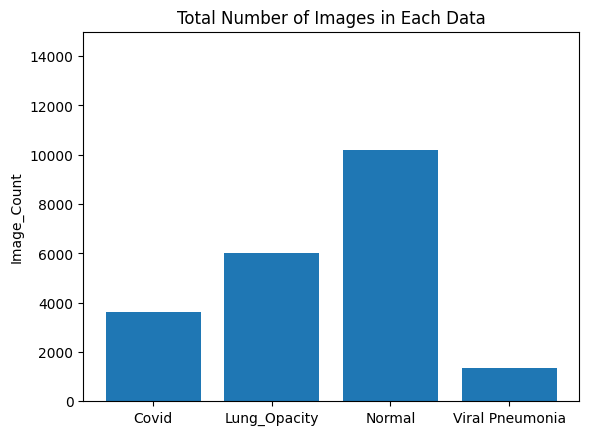

In [11]:
# Separate the header and the data
header = dataset[0]
rows = dataset[1:]

# Extract the folder names and image counts
folders = [row[0] for row in rows]
image_counts = [int(row[1]) for row in rows]

# Plot the data as a bar graph
plt.bar(folders, image_counts)
#plt.xlabel(header[0])
plt.ylabel(header[1])
plt.title('Total Number of Images in Each Data')
#plt.xticks(rotation=90)

# Set the y-axis limit to 15000
plt.ylim(0,15000)

plt.show()


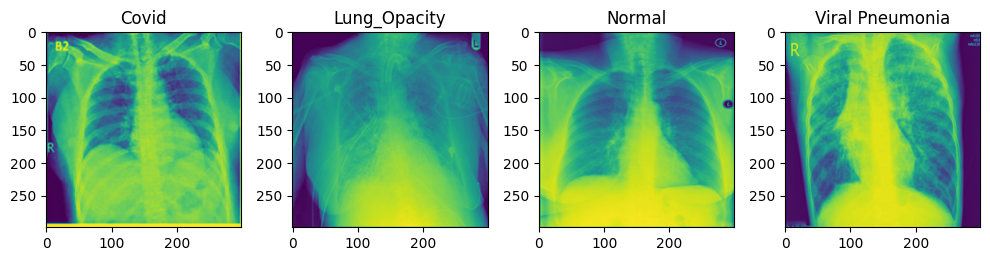

In [12]:

# Define the path to the dataset folder
dataset_paths = "C:/Users/LOKESH/Advange_Covid_19_prediction/covid19_radiography_database/covid19_radiography_database/COVID_19_Radiography_Dataset"

# Create a figure with 6 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 6))
axes = axes.flatten()

# Iterate over the folders and select a random image from each folder
folders = ["Covid","Lung_Opacity", "Normal", "Viral Pneumonia"]
for i, folder in enumerate(folders):
    folder_path = os.path.join(dataset_paths, folder)
    images = os.listdir(folder_path)
    
     
    # Select a random image from the folder
    random_image = random.choice(images)
    image_path = os.path.join(folder_path, random_image)
    image = plt.imread(image_path)
      
    
    # Plot the image in the subplot
    axes[i].imshow(image)
    axes[i].axis("on")  # Show axis
    axes[i].set_title(folder)
    
# Adjust the layout and spacing
plt.tight_layout()
plt.show()

# Data Augmentation

In [13]:
for covid in tqdm(os.listdir(dataset_path)):
    for i in range(len(os.listdir(dataset_path+ '/' + covid))):
        if i < 40:
            img = cv2.imread(dataset_path + '/' + covid + '/' + os.listdir(dataset_path+ '/' + covid)[i])
            resized_img = cv2.resize(img,(224,224))
            resized_img = resized_img / 255.0
            data.append(resized_img)
            class_name.append(covid)

data = np.array(data,dtype = 'float32')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s]


In [14]:
le = preprocessing.LabelEncoder()
le.fit(class_name)
class_names = le.classes_
class_name = le.transform(class_name)

class_name = np.array(class_name, dtype = 'uint8')
class_name = np.resize(class_name, (len(class_name),1))

##  Split the dataset into train and testing part

In [15]:
train_images, test_images, train_labels, test_labels = train_test_split(
    data, class_name, test_size=0.25, stratify = class_name
)

In [16]:
input_shape = (224, 224, 3)

#  Xception Model

In [17]:
from keras.applications.xception import Xception
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [18]:
xception_model = Sequential()

xception_base_model = Xception(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))
print(f'Number of layers in Xception model : {len(xception_base_model.layers)}')

Number of layers in Xception model : 132


In [19]:
for layer in xception_base_model.layers[:]:
    layer.trainable = False

for layer in xception_base_model.layers[4:]:
    layer.trainable = True

In [20]:
# adding AveragePooling2D and Output layer
xception_model.add(xception_base_model)
xception_model.add(GlobalAveragePooling2D())
xception_model.add(Dense(units = 4, activation = 'softmax'))

In [21]:
xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 20,814,220
Non-trainable params: 55,456
_________________________________________________________________


In [22]:
# callback processing statement
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( monitor = 'val_accuracy',
                               mode = 'max', min_delta = 1e-5, patience = 5, restore_best_weights = True, verbose = 0)


In [23]:
# Compile process
xception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [24]:
pwd

'C:\\Users\\LOKESH\\Advange_Covid_19_prediction'

In [25]:
# fit the model
xception = xception_model.fit(train_images, train_labels, batch_size = 32, epochs =50,
                              callbacks = [early_stopping], validation_split = 0.2)


Epoch 1/50
3/3 [==============================] - 43s 12s/step - loss: 1.2677 - accuracy: 0.4479 - val_loss: 1.2424 - val_accuracy: 0.5417
Epoch 2/50
3/3 [==============================] - 33s 12s/step - loss: 0.6913 - accuracy: 0.9583 - val_loss: 1.1572 - val_accuracy: 0.6667
Epoch 3/50
3/3 [==============================] - 31s 10s/step - loss: 0.3515 - accuracy: 1.0000 - val_loss: 1.0984 - val_accuracy: 0.7083
Epoch 4/50
3/3 [==============================] - 31s 11s/step - loss: 0.2155 - accuracy: 1.0000 - val_loss: 1.0616 - val_accuracy: 0.7083
Epoch 5/50
3/3 [==============================] - 30s 10s/step - loss: 0.1215 - accuracy: 1.0000 - val_loss: 1.0383 - val_accuracy: 0.7083
Epoch 6/50
3/3 [==============================] - 30s 10s/step - loss: 0.0748 - accuracy: 1.0000 - val_loss: 1.0212 - val_accuracy: 0.7083
Epoch 7/50
3/3 [==============================] - 29s 10s/step - loss: 0.0502 - accuracy: 1.0000 - val_loss: 1.0076 - val_accuracy: 0.7083
Epoch 8/50
3/3 [===========

In [26]:
 xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 20,814,220
Non-trainable params: 55,456
_________________________________________________________________


In [27]:
# Load the saved model
xception_model.save('xception_covid.h5')


loaded_model = load_model('xception_covid.h5')
print("Ya,It nearly over")

Ya,It nearly over


In [28]:
loaded_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002E8217AD6A0>>

Text(0, 0.5, 'Accuracy')

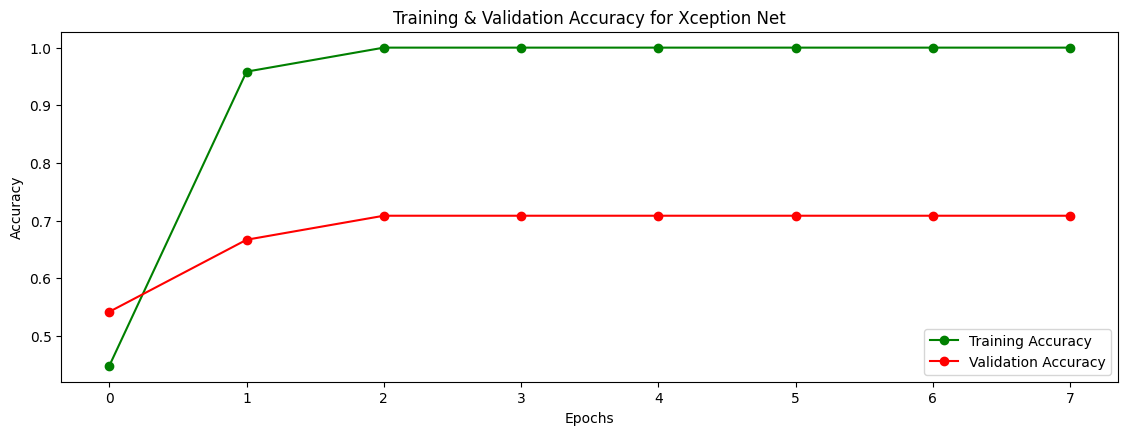

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,10))

plt.subplot(2,2,1)
i_train_acc = xception.history['accuracy']
i_val_acc = xception.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for Xception Net')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [30]:
#Testing for test data

xception_predictions = xception_model.predict(test_images)
xception_predictions = np.argmax(xception_predictions,axis = 1)

2/2 [==============================] - 3s 515ms/step


Text(0.5, 1.0, "Xception Model's Predicted Covid : ['Viral Pneumonia']")

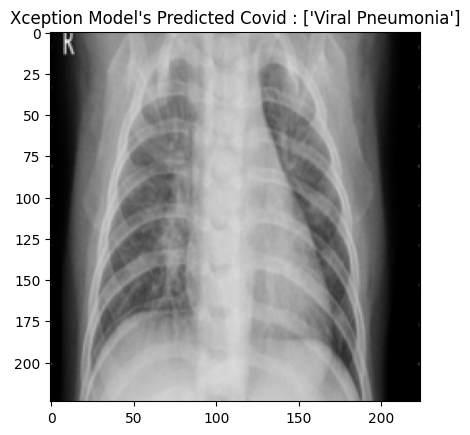

In [31]:
#Testing for test data
randomImage = np.random.randint(0,np.shape(test_images)[0])

plt.imshow(test_images[randomImage])
plt.title("Xception Model's Predicted Covid : " + str(le.inverse_transform([xception_predictions[randomImage]])))

# Custom Data

## Testing part-1

In [35]:
# Load the image
from tensorflow.keras.preprocessing import image
import numpy as np

image_path = 'COVID-46.png'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
# Expand the dimensions to match the expected input shape for Xception (4 dimensions)
img_array = np.expand_dims(img_array, axis=0)

In [36]:
# Preprocess the image

img_array = preprocess_input(img_array)
images_data = tf.image.resize(img_array, [224, 224])
# Make predictions on the image
prediction = loaded_model.predict(images_data)

1/1 [==============================] - 1s 721ms/step


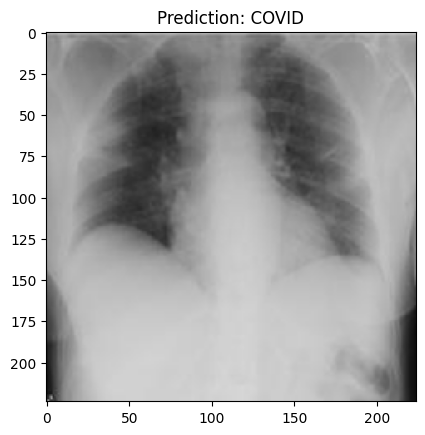

In [37]:
plt.imshow(img)
r=np.argmax(prediction)
plt.title(f'Prediction: {class_names[r]}')
plt.show()

## Testing part-2

In [38]:
# Load the image

image_path = 'Viral Pneumonia-5.png'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
# Expand the dimensions to match the expected input shape for Xception (4 dimensions)
img_array = np.expand_dims(img_array, axis=0)

In [39]:
# Preprocess the image

img_array = preprocess_input(img_array)
images_data = tf.image.resize(img_array, [224, 224])
# Make predictions on the image
prediction = loaded_model.predict(images_data)

1/1 [==============================] - 0s 116ms/step


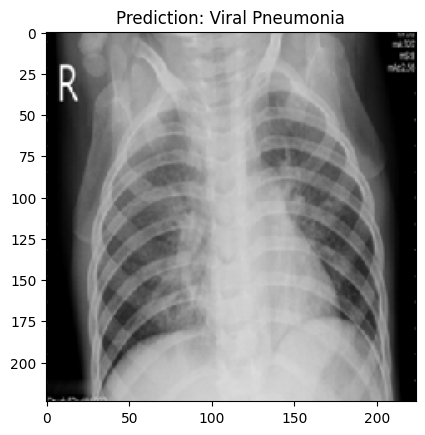

In [40]:
plt.imshow(img)
r=np.argmax(prediction)
plt.title(f'Prediction: {class_names[r]}')
plt.show()

## Testing part-3

In [47]:
# Load the image

image_path = 'Normal-30.png'
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
# Expand the dimensions to match the expected input shape for Xception (4 dimensions)
img_array = np.expand_dims(img_array, axis=0)

In [48]:
# Preprocess the image

img_array = preprocess_input(img_array)
images_data = tf.image.resize(img_array, [224, 224])
# Make predictions on the image
prediction = loaded_model.predict(images_data)

1/1 [==============================] - 0s 101ms/step


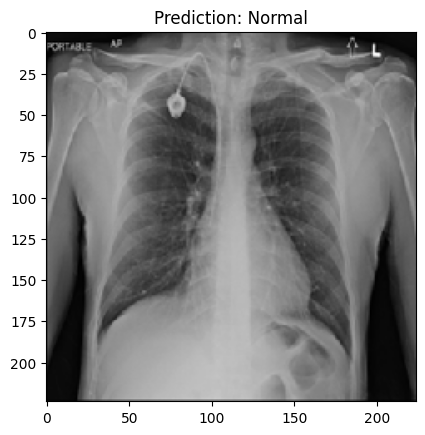

In [49]:
plt.imshow(img)
r=np.argmax(prediction)
plt.title(f'Prediction: {class_names[r]}')
plt.show()